In [7]:
"""Construct a dispersion relation for the two stream instability. """
from analysis import *
from adiplot import *
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from multiprocessing import Pool
from kineticdispersion2 import Solver, Species
from kineticdispersion3 import RelativisticSolver, RelativisticSpecies

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%matplotlib notebook

In [8]:
"""Define physical constants"""
e0 = 8.85E-12
mu0 = 1.26E-6
e = 1.6E-19
kb = 1.38E-23
me = 9.11E-31
ev = 11500
cl = 3E8

In [20]:
labelsize=9
fontsize=12

def miniFigure():
    """Sets up a small single figure. """
    fig, ax = plt.subplots(1, 1, figsize=(2.86, 2.42))
    plt.subplots_adjust(left=0.17, right=0.83, top=0.97, bottom=0.19)
    ax.tick_params('x', labelsize=labelsize)
    ax.tick_params('y', labelsize=labelsize)
    lbaxes = fig.add_axes([0.17, 0.19, 0.66, 0.78], frameon=False)
    lbaxes.set_xticks([])
    lbaxes.set_yticks([])
    lbaxes.yaxis.tick_right()
    lbaxes.tick_params('y', labelsize=labelsize)
    lbaxes.yaxis.set_label_position("left")
    return fig, ax, lbaxes

In [21]:
"""Define constants for the two stream instability"""
Te = ev*1 #Electron temperature of 1ev. 
B = 0.0000001 #Must define a negilible background magnetic field. 
density = 2.5E19 #Number density per metre cubed. 
v0 = cl/1000.0 #Drift velocity
vth = cl/1000000.0 #Thermal velocity
wpe = (density*e**2/(e0*me))**0.5 #Plasma frequency
wce = e*B/me #Electron cyclotron frequency

In [22]:
"""Set constants for plotting"""
wunit = wpe #The unit which we normalize frequency to. 
kunit = wunit/v0 #The unit we normalize wavenumber to. 
viewbounds = (0.0001, 2, -0.025, 2.0) #The range of values we plot within. 

In [23]:
"""Compute two streaming maxwellians. Distributions are truncated at 5vth"""
vpara1min = -5*vth - v0
vpara1max = 5*vth - v0
vpara2min = -5*vth + v0
vpara2max = 5*vth + v0
vperpmin = 0.0 #vperp starts at 0
vperpmax = 5*vth
nperp = 1000
npara = 1000
vpara1 = np.linspace(vpara1min, vpara1max, npara, dtype='float64')
vpara2 = np.linspace(vpara2min, vpara2max, npara, dtype='float64')
vperp = np.linspace(vperpmin, vperpmax, nperp, dtype='float64')
Fvpara1 = np.exp((-0.5*(vpara1 + v0)**2/(vth**2))) #Maxwellian distribution
Fvpara2 = np.exp((-0.5*(vpara2 - v0)**2/(vth**2)))
Fvperp = np.exp((-0.5*vperp**2/(vth**2)))
Fv1 = np.outer(Fvpara1, Fvperp)
Fv2 = np.outer(Fvpara2, Fvperp)

In [24]:
"""Create a species object for each beam. """
s1 = Species(-1*e, me, 0.5*density, vpara1, vperp, Fv1, np.arange(0, 1))
s2 = Species(-1*e, me, 0.5*density, vpara2, vperp, Fv2, np.arange(0, 1))

"""Create a dispersion solver using a list of species. """
solver = Solver(B, [s1, s2])

In [25]:
"""We can solve at any angle. Angle should not be zero for numerical reasons. """
theta = 0.000001*np.pi/180
"""ww defines the frequencies which we plot in the background"""
ww = np.linspace(viewbounds[2]*wpe, viewbounds[3]*wpe, 400)+ 0.0001j*wpe
kk = np.linspace(viewbounds[0]*kunit, viewbounds[1]*kunit, 100)
"""We use a 2D array of guesses, defined by a real and imaginary components wwr, wwi. """
wwr = np.linspace(-0.2*wpe, 2.0*wpe, 100)
wwi = np.linspace(0.000001j*wpe, 1.8j*wpe, 200)
ww2 = np.outer(wwr, np.ones(len(wwi))) + np.outer(np.ones(len(wwr)), wwi)
"""k has a parallel and perpendicular component. """
kkpara = kk*cos(theta)
kkperp = kk*sin(theta)
"""Set up the values of k we will solve for as a list. """
klist = np.array((kkpara, kkperp)).T

In [26]:
"""The problem is embarassingly parallel so we construct a process pool. """
"""Here we have used a desktop supporting 8 concurrent threads. """
pool = Pool(8)

"""Define functions to be mapped to the thread pool. """
def func(k):
    """Evaluate the insolution at k using ww. """
    marginalized = solver.marginalize(ww, k)
    return marginalized

def func2(k):
    """Find roots using the 2D initial guess array ww2. """
    roots = solver.roots(ww2, k)
    return roots

try:
    """We construct an array of insolution to plot. """
    insolution = pool.map_async(func, klist).get(99999)
    roots = pool.map_async(func2, klist).get(99999)
    pool.close()
except:
    pool.terminate() #When an exception is thrown we must terminate cleanly. 
    print 'Pool exception'
finally:
    pool.join()

In [27]:
insolution = np.array(insolution)

"""Post process the output into plottable format. """
root_w = []
root_k = []
for rootset, k in zip(roots, klist):
    for root in rootset:
        root_w.append(root[0])
        root_k.append((k[0]**2 + k[1]**2)**0.5*np.sign(k[0]))
        
root_w = np.array(root_w)
root_k = np.array(root_k)

"""We differentiate between small and large growth rates. """
growthmask = np.where(root_w.imag/wunit>1E-3)
stationarymask = np.where(root_w.imag/wunit<=1E-3)

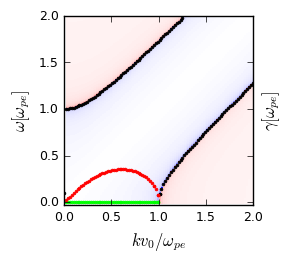

In [32]:
"""Finally we generate the figure. """
fig, ax, lbaxes = miniFigure()
lbaxes.yaxis.set_label_position("right")

im = ax.imshow((np.sign(insolution.real)/np.abs(insolution)**0.5).T,
               aspect='auto', interpolation='nearest', extent=viewbounds, 
               vmin=-2.5E1, vmax=2.5E1, origin='lower', cmap='bwr')
ax.plot(root_k[stationarymask]/kunit, root_w[stationarymask].real/wunit, 
        ls='None', marker='.', color='black', markersize=4)
ax.plot(root_k[growthmask]/kunit, root_w[growthmask].real/wunit, 
        ls='None', marker='.', color='lime', markersize=4)
ax.plot(root_k[growthmask]/kunit, root_w[growthmask].imag*1E0/wunit, 
        color='red', ls='None', marker='.', markersize=4)
ax.set_ylim(viewbounds[2], viewbounds[3])
ax.set_xlim(0, 2)

ax.set_xlabel('$kv_{0}/\omega_{pe}$', fontsize=fontsize)
ax.set_ylabel('$\omega[\omega_{pe}]$', fontsize=fontsize)
lbaxes.set_ylabel('$\gamma[\omega_{pe}]$', fontsize=fontsize)
ax.tick_params('x', labelsize=labelsize)
ax.tick_params('y', labelsize=labelsize)